In [1]:
import numpy as np
import pickle 
import scipy as sc
from scipy.signal import correlate2d
from scipy.signal import convolve2d
from scipy.signal import convolve
import h5py
import os


from matplotlib import pyplot as plt
from matplotlib import cm

from IPython.display import display, clear_output


## Load data

In [2]:
experiment_name = '20211109'

In [3]:
#read sta info
filename = f"/user/sebert/home/Documents/Experiments/Results/{experiment_name}_Thomas/resultfiles/{experiment_name}_sta_data.pkl"
with open(filename, "rb") as handle:   #Pickling
    stadict = pickle.load(handle)
    
stadict.keys()


dict_keys(['STAs', 'spatial', 'temporal', 'polarity', 'nb_spikes', 'rasters_check', 'rasters_check_repeated', 'is_STA'])

In [4]:
len(stadict['STAs'])

198

In [5]:

#import euler and other infos
filename = f"/user/sebert/home/Documents/Experiments/Results/{experiment_name}_Thomas/resultfiles/{experiment_name}_euler_grade_isi.pkl"
with open(filename, "rb") as handle:   #Pickling
    infodict = pickle.load(handle)
    
keys = list(infodict.keys())
keys.remove("euler_bin_edges")
n_cells = len(keys)

In [6]:
infodict[keys[1]]['isi'].min()

0.0005499999988387572

In [7]:

grades = []
rasters_chirp = []
for key in keys: 
    grades.append(infodict[key]['grade'])
    rasters_chirp.append(infodict[key]['control']['euler_raster'])

STAs = stadict['STAs']
rasters_check = stadict['rasters_check_repeated']
polarity_rf = stadict['polarity']


STAs = np.asarray(STAs)
rasters_check = np.asarray(rasters_check)
rasters_chirp = np.asarray(rasters_chirp)
STAs.shape, rasters_check.shape, rasters_chirp.shape

/user/sebert/home/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


((198, 40, 24, 24), (198, 90), (198, 20))

## Fit ellipses

In [8]:
def gaussian(height, center_x, center_y, width_x, width_y, rotation):
    width_x = float(width_x)
    width_y = float(width_y)

    rotation = np.deg2rad(rotation)
    center_x_ = center_x * np.cos(rotation) - center_y * np.sin(rotation)
    center_y_ = center_x * np.sin(rotation) + center_y * np.cos(rotation)
    
    center_x, center_y = center_x_, center_y_

    def rotgauss(x,y):
        xp = x * np.cos(rotation) - y * np.sin(rotation)
        yp = x * np.sin(rotation) + y * np.cos(rotation)
        g = height*np.exp(
            -(((center_x-xp)/width_x)**2+
              ((center_y-yp)/width_y)**2)/2.)
        return g
    return rotgauss

def moments(data):
    x,y = np.where(data==data.max())
    if len(x)>1:
        x = int(x[0])
        y = int(y[0])
    elif len(x)==1:
        x = int(x)
        y = int(y)
    else:
        x = 0
        y = 0

    col = data[:, int(y)]
    width_x = np.sqrt(abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y, 0.0

def fitgaussian(data):
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) - data)
    p, success = sc.optimize.leastsq(errorfunction, params)
    error = np.sum(errorfunction(params)**2)
    return p, success, error

def get_ellipse(parameters,factor=1.5):
    amplitude, x0, y0, sigma_x, sigma_y, theta = parameters
    width = factor * 2.0 * sigma_x
    height = factor * 2.0 * sigma_y

    t = np.linspace(0, 2*np.pi, 360)
    Ell = np.array([sigma_x*np.cos(t) , sigma_y*np.sin(t)])
    
    R_rot = np.array([[np.cos(-np.deg2rad(theta)) , -np.sin(-np.deg2rad(theta))]
                      ,[np.sin(-np.deg2rad(theta)) , np.cos(-np.deg2rad(theta))]])  
    
    Ell = np.dot(R_rot, Ell)
    Ell[0,:] += x0
    Ell[1,:] += y0
    ell_size = np.abs(np.pi*width*height)
    ell_meas = 1-min(width, height)/max(width, height)
    
    return Ell, ell_size, ell_meas

In [9]:
# Some parameters
#n_t_sta, nx, ny = STAs.shape[:3]
n_t_sta, nx, ny = STAs.shape[1:]
radius_px = 6
#stim_framerate = 30
stim_framerate = 40


# Smoothing kernel
Xin, Yin = np.mgrid[0:11, 0:11]
gaussian_kernel = gaussian(1,5,5,1,1,0)(Xin, Yin)
gaussian_kernel = gaussian_kernel/np.sum(gaussian_kernel)

# Define some storages
ellipses = np.zeros((2,360,n_cells))
ell_size = -np.ones(n_cells)
STA_time_course = np.zeros((n_cells, n_t_sta))

# Fit ellipses
for i_cell in range(n_cells):
#for i_cell in good_cells:
    #std_sta = np.std(STAs[:,:,:,i_cell],0)
    std_sta = np.std(STAs[i_cell,:,:,:],0)
    
    # Compute median over outside of the RF
    temp = []
    x_list = []
    y_list = []
    x_max, y_max = np.where(std_sta==std_sta.max())
    if len(x_max)>1:
        x_max = x_max[0]
        y_max = y_max[0]
    for i_x in range(nx):
        for i_y in range(ny):
            if np.sqrt((i_x-x_max)**2+(i_y-y_max)**2)>radius_px:
                temp += [std_sta[i_x,i_y]]
                x_list += [i_x]
                y_list += [i_y]
                
    # Level
    std_sta -= np.median(temp)
    for i in range(len(x_list)):
        i_x, i_y = x_list[i], y_list[i]
        std_sta[i_x,i_y] = 0
    std_sta[std_sta<0]=0

    # Smoothing
    std_sta = convolve2d(std_sta, gaussian_kernel, 'same', boundary='symm')
    std_sta = std_sta/np.sum(std_sta)
    
    # Fit
    Xin, Yin = np.mgrid[0:nx, 0:ny]
    temp_fit, success, error = fitgaussian(std_sta)

    # Check ellipse quality
    # If bad ellipse -> ell_size = -1
    if success:
        ellipses[:,:,i_cell], ell_size_temp, ell_meas = get_ellipse(temp_fit)
        if ell_size_temp<2e3 and ell_meas<0.95:
            ell_size[i_cell] = ell_size_temp
            
    # Extract time course
    if ell_size[i_cell] != -1:
        gauss_temp = gaussian(*temp_fit)(Xin, Yin)
        gauss_temp = gauss_temp/np.sum(gauss_temp)
        #STA_time_course[i_cell,:] = np.sum(STAs[:,:,:,i_cell]*gauss_temp[None,:,:], (1,2))       
        STA_time_course[i_cell,:] = np.sum(STAs[i_cell,:,:,:]*gauss_temp[None,:,:], (1,2))

/tmp/ipykernel_1035012/3257739440.py:49: RuntimeWarning: invalid value encountered in true_divide
  std_sta = std_sta/np.sum(std_sta)
/user/sebert/home/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  warnings.warn(errors[info][0], RuntimeWarning)


In [30]:
# Validate the ellipses

processed_list = []
is_STA = []
print('Press 1 to validate the ellipse, 0 to discard it.')
i_cell = 0
while i_cell < n_cells:

    fig = plt.figure(figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')
    plt.subplot(1,2,1)
    plt.title(f'Cell #{i_cell}, Grade {grades[i_cell]}')
    #plt.imshow(np.std(STAs[:,:,:,i_cell],0))
    plt.imshow(np.std(STAs[i_cell,:,:,:],0))
    plt.colorbar()
    plt.plot(ellipses[1,:,i_cell], ellipses[0,:,i_cell])
    plt.subplot(1,2,2)
    time_bins = np.arange(-n_t_sta*1e3/stim_framerate, 0, 1e3/stim_framerate)
#         x_max, y_max = np.where(np.std(STAs[:,:,:,i_cell],0)==np.std(STAs[:,:,:,i_cell],0).max())
#         plt.plot(time_bins, STAs[:,x_max,y_max,i_cell])
    plt.plot(STA_time_course[i_cell,:])
    plt.title(f'Max pos {x_max,y_max}')
    plt.xlabel('time (ms)')
    plt.tight_layout()
    plt.show()

    clear_output(wait=True)
    user_input = input()
    if user_input == '1':
        is_STA.append("yes")
        processed_list += [i_cell]
    elif user_input == '0':
        processed_list += [i_cell]
        is_STA.append("no")
        ell_size[i_cell] = -1
    else:
        i_cell -= 1
        print('Try again', end='\r')
    i_cell+= 1

1


In [10]:
stadict["ellipses"] = ellipses


In [13]:

filename = f"/user/sebert/home/Documents/Experiments/Results/{experiment_name}_Thomas/resultfiles/{experiment_name}_sta_data.pkl"
with open(filename, "wb") as handle:   #Pickling
    pickle.dump(stadict, handle,protocol=pickle.HIGHEST_PROTOCOL )

In [12]:
stadict.keys()

dict_keys(['STAs', 'spatial', 'temporal', 'polarity', 'nb_spikes', 'rasters_check', 'rasters_check_repeated', 'is_STA', 'ellipses'])

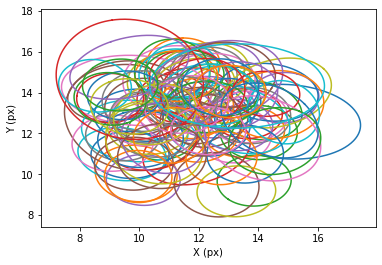

In [34]:
for i_cell in range(n_cells):
    if ell_size[i_cell]!=-1:
        plt.plot(ellipses[1,:,i_cell], ellipses[0,:,i_cell])
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

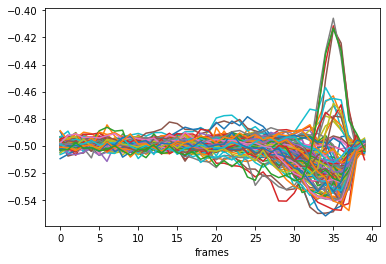

103 Cells with STA


In [35]:
time_bins = np.arange(-n_t_sta*1e3/stim_framerate, 0, 1e3/stim_framerate)
for i_cell in range(n_cells):
    if ell_size[i_cell]!=-1:
#         i_x, i_y = np.where(np.std(STAs[:,:,:,i_cell], 0)==np.std(STAs[:,:,:,i_cell], 0).max())
#         plt.plot(time_bins, STAs[:,i_x,i_y,i_cell])
        plt.plot(STA_time_course[i_cell,:])
        
plt.xlabel('frames')
plt.show()
print(f"{np.sum(ell_size!=-1)} Cells with STA")

In [70]:
#count ON and OFF cells
nb_ON = 0
nb_OFF = 0
nb_yes = 0
nb_no = 0
for i in range(n_cells):
    
    if stadict['is_STA'][i] == 'yes':
        nb_yes = nb_yes +1
        
        if stadict['polarity'][i] == "ON":
            nb_ON = nb_ON +1
            
        if stadict['polarity'][i] == "OFF":
            nb_OFF = nb_OFF +1
            
    else: 
        nb_no = nb_no + 1


if n_cells == nb_OFF + nb_ON + nb_no:
    print("all STAs evaluated")
    print(f'out of {n_cells} cells,\n{nb_ON} cells have an ON STA, \n {nb_OFF} cells have an OFF STA and \n {nb_no} cells have no clear STA')
else:
    print(f'{n_cells - (nb_ON+ nb_OFF + nb_no)} cells are missing')

all STAs evaluated
out of 198 cells,
16 cells have an ON STA, 
 94 cells have an OFF STA and 
 88 cells have no clear STA


yes
OFF <class 'str'>
yes
ON <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
ON <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
ON <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
ON <class 'str'>
yes
ON <class 'str'>
yes
ON <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
ON <class 'str'>
yes
ON <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'str'>
yes
OFF <class 'st

In [47]:
nb_cells_ON

2

In [28]:
# Validate the ellipses

processed_list = []
is_STA = []
print('Press 1 to validate the ellipse, 0 to discard it.')
i_cell = 0
while i_cell < n_cells:
    if ell_size[i_cell] == -2:#-1:
        processed_list += [i_cell]
    elif ell_size[i_cell] != -1:
        fig = plt.figure(figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')
        plt.subplot(1,2,1)
        plt.title(f'Cell #{i_cell}, Grade {grades[i_cell]}')
        #plt.imshow(np.std(STAs[:,:,:,i_cell],0))
        plt.imshow(np.std(STAs[i_cell,:,:,:],0))
        plt.colorbar()
        plt.plot(ellipses[1,:,i_cell], ellipses[0,:,i_cell])
        plt.subplot(1,2,2)
        time_bins = np.arange(-n_t_sta*1e3/stim_framerate, 0, 1e3/stim_framerate)
#         x_max, y_max = np.where(np.std(STAs[:,:,:,i_cell],0)==np.std(STAs[:,:,:,i_cell],0).max())
#         plt.plot(time_bins, STAs[:,x_max,y_max,i_cell])
        plt.plot(STA_time_course[i_cell,:])
        plt.title(f'Max pos {x_max,y_max}')
        plt.xlabel('time (ms)')
        plt.tight_layout()
        plt.show()

        clear_output(wait=True)
        user_input = input()
        if user_input == '1':
            is_STA.append("yes")
            processed_list += [i_cell]
        elif user_input == '0':
            processed_list += [i_cell]
            is_STA.append("no")
            ell_size[i_cell] = -1
        else:
            i_cell -= 1
            print('Try again', end='\r')
    i_cell+= 1

1


## Bin spikes

In [15]:
# Bin spike trains
def bin_spike_trains(spikes, dt, stim_lenght):

    n_cells = len(spikes)
    n_rep = len(spikes[0])
    n_t = int(stim_lenght/dt)
    
    binned_spikes = np.zeros((n_cells, n_t, n_rep))
    time_bins = np.arange(0,(n_t+1)*dt, dt)

    for i_cell in range(n_cells):
        for i_rep in range(n_rep):
            binned_spikes[i_cell,:,i_rep] = np.histogram(spikes[i_cell][i_rep], bins=time_bins)[0][:n_t]

    return binned_spikes

In [16]:
#np.histogram(rasters_chirp[0][0], bins=time_bins)[0]

In [17]:
# Checkerboard
stim_lenght = 15#40 # seconds
dt = 3e-3 # seconds
#spikes_check = bin_spike_trains(rasters_check, dt, stim_lenght)
spikes_check = bin_spike_trains(rasters_check, dt, stim_lenght)
spikes_check = spikes_check[:,:,-80:]
n_rep_check = spikes_check.shape[-1]

# Chirp
stim_lenght = 30
dt = 1e-2
spikes_chirp = bin_spike_trains(rasters_chirp, dt, stim_lenght)
n_rep_chirp = spikes_chirp.shape[-1]
psth_chirp = np.mean(spikes_chirp, 2)

## Find and merge splits

### Search potential splits

In [18]:
subpop = np.where(ell_size>-1)[0]
n_sub_cells = subpop.shape[0]
subpop_ellipses = ellipses[:,:,subpop]

pos_arr = np.mean(subpop_ellipses, 1)
x_list = pos_arr[0,:]
y_list = pos_arr[1,:]
dist_arr = np.sqrt((x_list[:,None]-x_list[None,:])**2 + (y_list[:,None]-y_list[None,:])**2)

tril_idx =  np.tril_indices(n_sub_cells)
dist_arr[tril_idx] = np.Inf

dist_thres = 0.2
pot_splits = np.array(np.where(dist_arr<=dist_thres))

splits_list = []
i_pair = -1

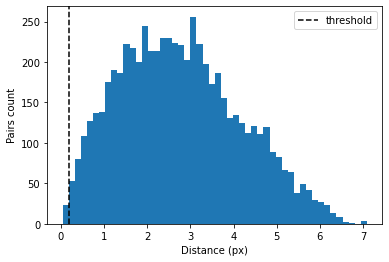

Number of potential splits: 26


In [19]:
triu_idx = np.triu_indices(n_sub_cells,1)
plt.hist(dist_arr[triu_idx], 50)
plt.axvline(dist_thres, linestyle='--', color='k', label='threshold')
plt.xlabel('Distance (px)')
plt.ylabel('Pairs count')
plt.legend()
plt.show()

print(f'Number of potential splits: {pot_splits.shape[1]}')

In [20]:
def plot_panel():
    plt.figure(figsize=(12,10), dpi= 100, facecolor='w', edgecolor='k')

    plt.subplot(5,3,1)
    plt.plot(psth_chirp[pair[0],:], linewidth=3, label='Cell A')
    plt.plot(psth_chirp[pair[1],:], label='Cell B')
    plt.legend()

    plt.subplot(5,3,2)
    plt.title(f'Cells {tuple(pair)}')
    plt.plot(ellipses[0,:,subpop].transpose(), ellipses[1,:,subpop].transpose(), '-k')
    plt.plot(ellipses[0,:,pair[0]], ellipses[1,:,pair[0]])
    plt.plot(ellipses[0,:,pair[1]], ellipses[1,:,pair[1]])

    plt.subplot(5,3,3)
    plt.plot(np.arange(-max_corr_time,max_corr_time+1)*bin_size, x_corr_noise)
    plt.axvline(0, linestyle='--', color = 'k')
    plt.xlabel('delay')
    plt.ylabel('noise x-correlations')

    plt.subplot(5,3,4)
    plt.bar(np.arange(1, max_tau+1), isi_count0)
    plt.title(f'Cell A: grade {grades[pair[0]]}')
    plt.ylabel('Count')
    plt.xlabel('ISI (ms)')

    plt.subplot(5,3,5)
    plt.bar(np.arange(1, max_tau+1), isi_count1)
    plt.title(f'Cell B: grade {grades[pair[1]]}')
    plt.xlabel('ISI (ms)')
    plt.ylabel('Count')

    plt.subplot(5,3,6)
    plt.bar(np.arange(0, max_tau+1), isi_count01)
    plt.title('Cell AxB')
    plt.xlabel('pair ISI (ms)')
    plt.ylabel('Count')

    plt.subplot(5,3,7)
    plt.eventplot(spikes_trainc0, color='k')
    plt.title('Chirp - cell A')
    plt.xlim(0,3000)
    plt.xlabel('time (ms)')
    plt.ylabel('repeats')

    plt.subplot(5,3,10)
    plt.eventplot(spikes_trainc1, color='k')
    plt.title('Chirp - cell B')
    plt.xlim(0,3000)
    plt.xlabel('time (ms)')
    plt.ylabel('repeats')

    plt.subplot(5,3,(8,9))
    plt.eventplot(spikes_train0, color='k')
    plt.title('Checker - cell A')
    plt.xlim(0,5000)
    plt.xlabel('time (ms)')
    plt.ylabel('repeats')

    plt.subplot(5,3,(11,12))
    plt.eventplot(spikes_train1, color='k')
    plt.title('Checker - cell B')
    plt.xlim(0,5000)
    plt.xlabel('time (ms)')
    plt.ylabel('repeats')
    
    plt.subplot(5,3,13)
    plt.eventplot(spikes_trainc1, color='b', alpha = .5, label = 'cell B')
    plt.eventplot(spikes_trainc0, color='r', alpha = .5, label = 'cell A')
    plt.xlim(0,3000)
    plt.title('Chirp - overlap')
    plt.xlabel('time (ms)')
    plt.ylabel('repeats')
    
    plt.subplot(5,3,(14,15))
    plt.eventplot(spikes_train1, color='b', alpha = .5, label = 'cell B')
    plt.eventplot(spikes_train0, color='r', alpha = .5, label = 'cell A')
    plt.xlim(0,5000)
    plt.title('Checker - overlap')
    plt.xlabel('time (ms)')
    plt.ylabel('repeats')

    plt.tight_layout()
    plt.show()

0


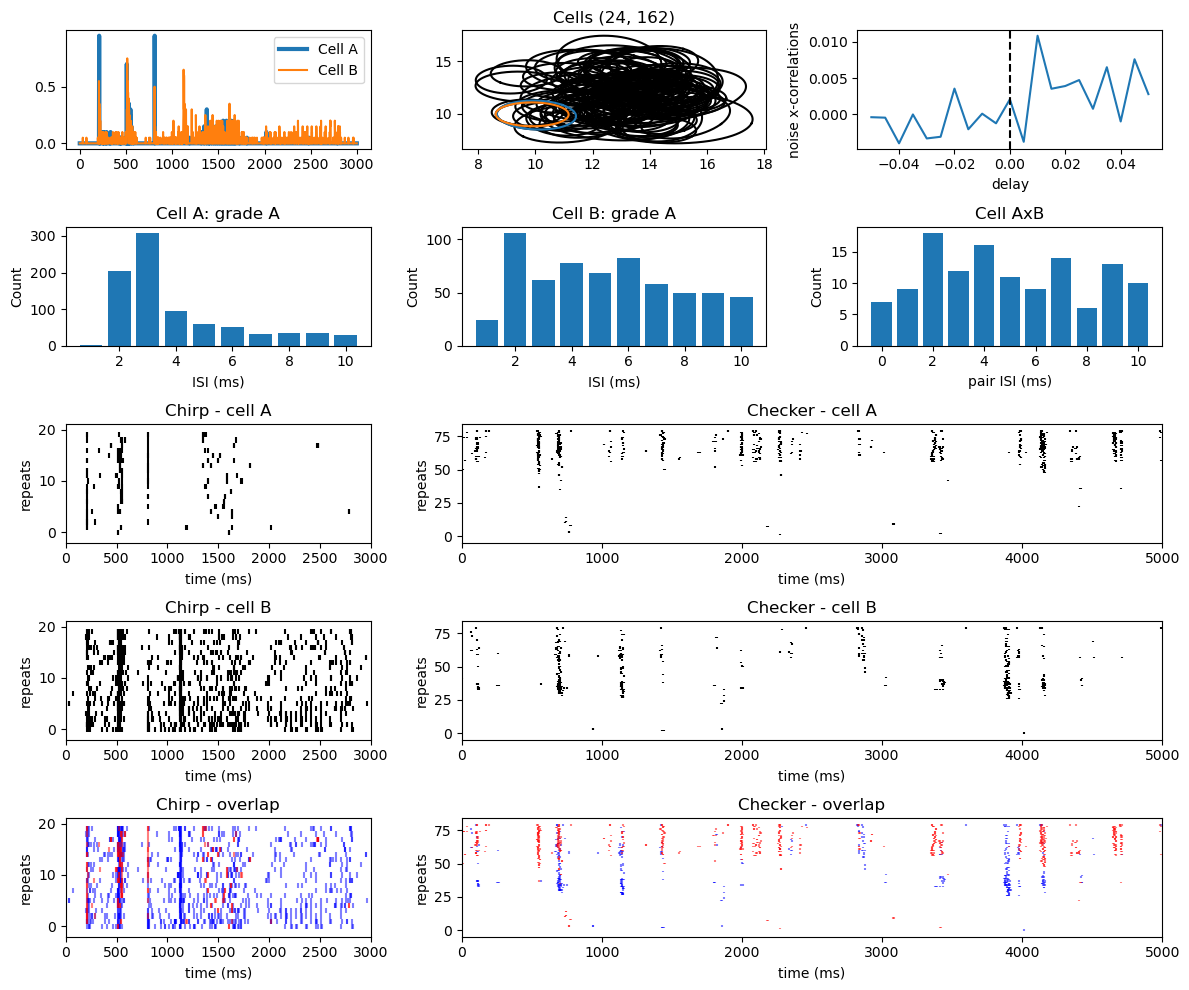

In [ ]:

# Iterate over all pairs

bin_size = 5e-3
spikes_expb = spikes_check

max_corr_time = 10
nt_max = 10000

pairs_to_merge = []
n_pot_pairs = pot_splits.shape[1]

i_pair = 0
while i_pair<n_pot_pairs:

    pair = subpop[pot_splits[:,i_pair]]
    spikes_pair = spikes_expb[pair,:,:]
    
    # Xcorr
    spikes_pair0 = spikes_pair[:,:nt_max,:] -np.mean(spikes_pair[:,:nt_max,:], 2)[:,:,None]
    x = spikes_pair0[0,:,:]
    y = spikes_pair0[1,max_corr_time:-max_corr_time,:]

    var_tot = np.sqrt(np.var(x, ddof=0)*np.var(y, ddof=0))
    x_corr_noise = correlate2d(x, y, 'valid', 'fill')/var_tot/(x.shape[0]*x.shape[1])

    # ISI histogram cell A
    i_cell = 0
    j_cell = 0
    max_tau = 10
    isi_count0 = np.zeros(max_tau)
    for tau in np.setdiff1d(np.arange(-max_tau,max_tau+1), 0):
        isi_count0[np.abs(tau)-1] += np.sum(np.roll(spikes_pair[i_cell,:,:], -tau, axis=0)==spikes_pair[j_cell,:,:]*2-1)

    # ISI histogram cell B
    i_cell = 1
    j_cell = 1
    max_tau = 10
    isi_count1 = np.zeros(max_tau)
    for tau in np.setdiff1d(np.arange(-max_tau,max_tau+1), 0):
        isi_count1[np.abs(tau)-1] += np.sum(np.roll(spikes_pair[i_cell,:,:], -tau, axis=0)==spikes_pair[j_cell,:,:]*2-1)


    # ISI histogram AxB
    i_cell = 1
    j_cell = 0
    max_tau = 10
    isi_count01 = np.zeros(max_tau+1)
    for tau in np.arange(-max_tau,max_tau+1):
        isi_count01[np.abs(tau)] += np.sum(np.roll(spikes_pair[i_cell,:,:], tau, axis=0)==spikes_pair[j_cell,:,:]*2-1)

    # Spike trains
    spikes_trainc0 = [list(np.where(spikes_chirp[pair[0],:,repe]==1)[0]) for repe in range(n_rep_chirp)]
    spikes_trainc1 = [list(np.where(spikes_chirp[pair[1],:,repe]==1)[0]) for repe in range(n_rep_chirp)]
    spikes_train0 = [list(np.where(spikes_pair[0,:,repe]==1)[0]) for repe in range(n_rep_check)]
    spikes_train1 = [list(np.where(spikes_pair[1,:,repe]==1)[0]) for repe in range(n_rep_check)]
    
    # Plot
    plot_panel()
    
    # User input
    clear_output(wait=True)
    user_input = input()
    
    if user_input == '1':
        i_pair += 1
        pairs_to_merge += [list(pair)]
    elif user_input == 'p':
        i_pair -= 1
        if pairs_to_merge[-1] == pot_splits[i_pair]:
            pairs_to_merge.pop()
    elif user_input == '0':
        i_pair += 1
    else:
        print('Try again', end='\r')

In [32]:
print(f'{len(pairs_to_merge)} Pairs of cells to merge: {pairs_to_merge}')

4 Pairs of cells to merge: [[12, 92], [35, 40], [70, 71], [141, 158]]
